<h1>개인 구글 드라이브와 colab 연동</h1>

In [ ]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


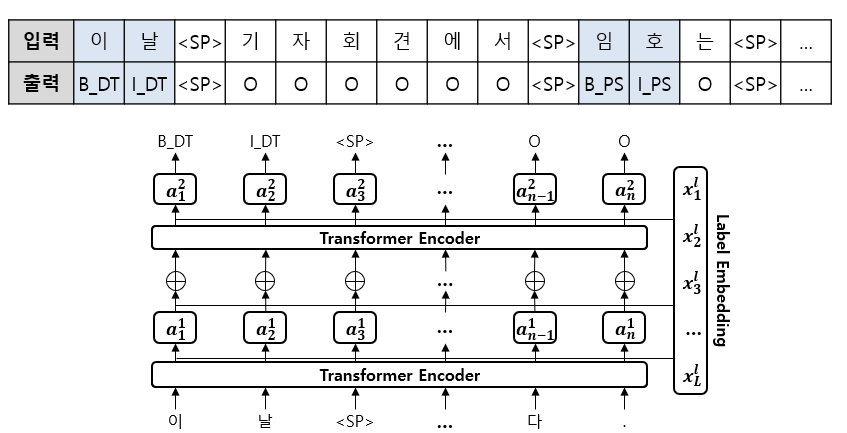

In [ ]:
from IPython.display import Image
Image("/gdrive/MyDrive/08-1.NamedEntitYRecognition")

<h1>TRANSFORMER_LAN 모델을 이용한 개체명 인식</h1>

In [ ]:
import torch
import torch.nn as nn


class TRANSFORMER_LAN(nn.Module):

    def __init__(self, config):
        super(TRANSFORMER_LAN, self).__init__()

        # 전체 character 개수
        self.character_vocab_size = config["character_vocab_size"]

        # character 임베딩 사이즈
        self.embedding_size = config["embedding_size"]

        # 최대 길이 (character 기준)
        self.max_length = config["max_length"]

        # Transformer 히든 사이즈
        self.hidden_size = config["hidden_size"]

        # Transformer head 개수
        self.num_heads = config["num_heads"]

        # Transformer layer 개수
        self.num_layers = config["num_layers"]

        # 분류할 라벨의 개수
        self.num_of_labels = config["num_of_labels"]

        self.dropout = nn.Dropout(config["dropout"])

        # character index를 대응하는 벡터로 치환해주기 위한 임베딩 객체
        self.embedding = nn.Embedding(num_embeddings=self.character_vocab_size,
                                      embedding_dim=self.embedding_size,
                                      padding_idx=0)
        # 입력 데이터의 각 character들의 위치 정보를 반영해주기 위한 임베딩 객체
        self.position_embedding = nn.Embedding(num_embeddings=self.max_length,
                                               embedding_dim=self.embedding_size)
        self.embedding_layer_norm = nn.LayerNorm(normalized_shape=self.embedding_size)

        # 분류할 각 라벨에 대응하는 임베딩 벡터들을 갖고 있는 행렬
        self.label_embedding = nn.Parameter(torch.randn(size=(self.num_of_labels, self.hidden_size),
                                                        dtype=torch.float32,
                                                        requires_grad=True))
        # Transformer encoder layer
        self.first_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(
                                                  d_model=self.hidden_size,
                                                  nhead=self.num_heads,
                                                  dim_feedforward=self.hidden_size,
                                                  batch_first=True),
                                                  num_layers=self.num_layers)

        # Transformer encoder layer
        self.second_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(
                                                  d_model=self.hidden_size,
                                                  nhead=self.num_heads,
                                                  dim_feedforward=self.hidden_size,
                                                  batch_first=True),
                                                  num_layers=self.num_layers)

        self.linear = nn.Linear(in_features=self.hidden_size * 2, out_features=self.hidden_size)

        # Multi-head attention layer
        self.first_multi_head_attention = Multihead_Attention(hidden_size=self.hidden_size,
                                                              num_heads=self.num_heads,
                                                              dropout_rate=config["dropout"])

        # Multi-head attention layer
        self.second_multi_head_attention = Multihead_Attention(hidden_size=self.hidden_size,
                                                               num_heads=1,
                                                               dropout_rate=config["dropout"])

    def forward(self, inputs, positions):
        # inputs : (batch_size, max_length)
        # positions : (batch_size, max_length)

        batch_size = inputs.size()[0]

        # label_embedding : (1, num_of_labels, hidden)
        label_embedding = self.label_embedding.clone().unsqueeze(dim=0)

        # label_embedding : (batch_size, num_of_labels, hidden)
        label_embedding = label_embedding.repeat(batch_size, 1, 1)

        # character_inputs : (batch_size, max_length, embedding_size)
        character_inputs = self.embedding(inputs) + self.position_embedding(positions)
        character_inputs = self.embedding_layer_norm(character_inputs)
        character_inputs = self.dropout(character_inputs)

        # first_encoder_output : (batch_size, max_length, hidden_size)
        first_encoder_output = self.first_encoder(src=character_inputs, 
                                                  src_key_padding_mask= (inputs == 0))

        # first_attention_outputs : (batch_size, max_length, hidden_size)
        first_attention_outputs, _ = self.first_multi_head_attention(queries=first_encoder_output,
                                                                     keys=label_embedding,
                                                                     values=label_embedding,
                                                                     last_layer=False)

        # middle_outputs : (batch_size, max_length, hidden_size*2)
        middle_outputs = torch.cat(tensors=[first_encoder_output, first_attention_outputs], dim=-1)

        # middle_outputs : (batch_size, max_length, hidden_size)
        middle_outputs = self.linear(middle_outputs)

        # second_encoder_output : (batch_size, max_length, hidden_size)
        second_encoder_output = self.second_encoder(src=middle_outputs, 
                                                    src_key_padding_mask=(inputs == 0))

        # second_attention_weights : (batch_size, max_length, num_of_labels)
        _ , second_attention_weights = self.second_multi_head_attention(queries=second_encoder_output,
                                                                        keys=label_embedding,
                                                                        values=label_embedding,
                                                                        last_layer=True)

        return second_attention_weights


class Multihead_Attention(nn.Module):

    def __init__(self, hidden_size, num_heads=1, dropout_rate=0):
        super(Multihead_Attention, self).__init__()

        # 히든 사이즈
        self.hidden_size = hidden_size
        
        # head 개수
        self.num_heads = num_heads

        self.dropout = nn.Dropout(dropout_rate)

        # query, key, value를 위한 비선형 함수
        self.query_linear = nn.Sequential(nn.Linear(self.hidden_size, self.hidden_size), nn.ReLU())
        self.key_linear = nn.Sequential(nn.Linear(self.hidden_size, self.hidden_size), nn.ReLU())
        self.value_linear = nn.Sequential(nn.Linear(self.hidden_size, self.hidden_size), nn.ReLU())

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, queries, keys, values, last_layer=False):
        Q = self.query_linear(queries)  # (N, T_q, C)
        K = self.key_linear(keys)  # (N, T_q, C)
        V = self.value_linear(values)  # (N, T_q, C)

        Q_ = torch.cat(torch.chunk(Q, self.num_heads, dim=2), dim=0)  # (h*N, T_q, C/h)
        K_ = torch.cat(torch.chunk(K, self.num_heads, dim=2), dim=0)  # (h*N, T_q, C/h)
        V_ = torch.cat(torch.chunk(V, self.num_heads, dim=2), dim=0)  # (h*N, T_q, C/h)

        # attention_weights : (batch_size * num_heads, max_length, num_of_labels)
        attention_weights = torch.bmm(Q_, K_.permute(0, 2, 1))
        attention_weights = attention_weights / (K_.size()[-1] ** 0.5)
        if(last_layer == False):
            attention_weights = self.softmax(attention_weights)

        # query_masks : (batch_size, max_length)
        query_masks = torch.sign(torch.abs(torch.sum(queries, dim=-1)))
        # query_masks : (batch_size * num_heads, max_length)
        query_masks = query_masks.repeat(self.num_heads, 1)
        # query_masks : (batch_size * num_heads, max_length, num_of_labels)
        query_masks = torch.unsqueeze(query_masks, 2).repeat(1, 1, keys.size()[1])

        # attention_weights : (batch_size * num_heads, max_length, num_of_labels)
        attention_weights = attention_weights * query_masks
        attention_weights = self.dropout(attention_weights)  # (h*N, T_q, T_k)

        # attention_outputs : (batch_size * num_heads, max_length, hidden_size / num_heads)
        attention_outputs = torch.bmm(attention_weights, V_)
        # attention_outputs : (batch_size, max_length, hidden_size)
        attention_outputs = torch.cat(torch.chunk(attention_outputs, self.num_heads, dim=0), dim=2)

        # attention_outputs : (batch_size, max_length, hidden_size)
        # attention_weights : (batch_size * num_heads, max_length, num_of_labels)
        return attention_outputs, attention_weights

<h1>데이터 읽고 전처리 하기</h1>

<pre>
<b>1. read_data(file_path)</b>
  "train_datas.txt", "test_datas.txt" 파일을 읽기 위한 함수
  
  데이터 예시)
    골 프 ＜SP＞ 유 망 주 ＜SP＞ 정 지 호 \t O O ＜SP＞ O O O ＜SP＞ B_PS I_PS I_PS
  
  read_file(file_path)
  args
    file_path : 읽고자 하는 데이터의 경로
  return
    datas : character sequence, 각 character에 대응하는 라벨 sequence를 담고 있는 리스트
    
    출력 예시)
      datas = [
        (["골", "프", "＜SP＞", "유", "망", "주", "＜SP＞" "정", "지", "호"],
         ["O", "O", "＜SP＞", "O", "O", "O", "＜SP＞", "B_PS", "I_PS", "I_PS"])

        (...),
        
        ]
      
<b>2. read_vocab_data(vocab_data_path)</b>
  "character_vocab.txt", "label_vocab.txt" 파일을 읽고 character와 라벨을 indexing하기 위한 딕셔너리를 생성
   
  read_vocab_data(vocab_data_path)
  args
    vocab_data_path : 어휘 파일 경로
  return  
    term2idx : character 또는 라벨을 대응하는 index로 치환하기 위한 딕셔너리
    idx2term : index를 대응하는 character 또는 라벨로 치환하기 위한 딕셔너리

    
<b>3. convert_data2feature(datas, max_length, character2idx, label2idx)</b>
  입력 데이터를 고정된 길이로 변환 후 indexing
  Tensor로 변환
   
  convert_data2feature(datas, max_length, character2idx, label2idx)
  args
    datas : character sequence, 각 character에 대응하는 라벨 sequence를 담고 있는 리스트
    max_length : 입력의 최대 길이
    character2idx : character를 대응하는 index로 치환하기 위한 딕셔너리
    label2idx : 라벨을 대응하는 index로 치환하기 위한 딕셔너리
  return
    character_features : index로 치환된 character sequence
    position_features : 각 character의 위치 정보를 담고 있는 위치 sequence
    label_features : index로 치환된 라벨 sequence
    
  전처리 예시)
    datas = [(["골", "프", "＜SP＞", "유", "망", "주", "＜SP＞" "정", "지", "호"],
            ["O", "O", "＜SP＞", "O", "O", "O", "＜SP＞", "B_PS", "I_PS", "I_PS"]),

    (...),
    
    ]
    
    사전 설정한 문장의 최대 길이를 12이라고 가정
    
    ["골", "프", "＜SP＞", "유", "망", "주", "＜SP＞" "정", "지", "호"] 
    ->
    ["골", "프", "＜SP＞", "유", "망", "주", "＜SP＞" "정", "지", "호", "＜PAD＞", "＜PAD＞"]

    ["골", "프", "＜SP＞", "유", "망", "주", "＜SP＞" "정", "지", "호", "＜PAD＞", "＜PAD＞"]
    ->
    [ 23, 2, 55, 65, 96, 12, 55, 19, 34, 5, 0, 0 ]
    

    ["O", "O", "＜SP＞", "O", "O", "O", "＜SP＞", "B_PS", "I_PS", "I_PS"]
    ->
    ["O", "O", "＜SP＞", "O", "O", "O", "＜SP＞", "B_PS", "I_PS", "I_PS", "＜PAD＞", "＜PAD＞"]

    ["O", "O", "＜SP＞", "O", "O", "O", "＜SP＞", "B_PS", "I_PS", "I_PS", "＜PAD＞", "＜PAD＞"]
    ->
    [ 1, 1, 2, 1, 1, 1, 2, 3, 4, 4, 0, 0 ]    

    character_features : Tensor([ 23, 2, 55, 65, 96, 12, 55, 19, 34, 5, 0, 0 ], [...], ...)
    position_features : Tensor([0, 1, 2, 3, 4, 5, ..., ])
    label_features : Tensor([ 1, 1, 2, 1, 1, 1, 2, 3, 4, 4, 0, 0 ], [...], ...)
 </pre>


In [ ]:
import torch
import numpy as np
import re
from tqdm import tqdm

# 학습 or 평가 데이터를 읽어 리스트에 저장
def read_data(file_path):
    with open(file_path, "r", encoding="utf8") as inFile:
        lines = inFile.readlines()

    datas = []
    for line in tqdm(lines, desc="read_data"):
        # 입력 문장을 \t을 기준으로 분리
        pieces = line.strip().split("\t")

        # 입력 데이터를 character 단위로 분리
        character_sequence, label_sequence = pieces[0].split(), pieces[1].split()

        # character_sequence의 길이와 라벨 sequence의 길이가 동일한지 체크
        assert len(character_sequence) == len(label_sequence)

        datas.append((character_sequence, label_sequence))

    return datas


# 데이터를 읽고 각각의 딕셔너리 생성
def read_vocab_data(vocab_data_path):
    term2idx, idx2term = {"<PAD>":0}, {0:"<PAD>"}

    with open(vocab_data_path, "r", encoding="utf8") as inFile:
        lines = inFile.readlines()

    for line in lines:
        term = line.strip()
        term2idx[term] = len(term2idx)
        idx2term[term2idx[term]] = term

    return term2idx, idx2term


# 입력 데이터 전처리
def convert_data2feature(datas, max_length, character2idx, label2idx):
    # character 데이터, character 위치 데이터, 라벨 데이터를 담을 리스트
    character_features, position_features, label_features = [], [], []

    for character_sequence, label_sequence in tqdm(datas, desc="convert_data2feature"):
        # 숫자를 0으로 치환
        # 예시) 1 년 <SP> 6 개 월 -> 0 년 <SP> 0 개 월
        character_sequence = [e if e != '<SP>' else ' ' for e in re.sub("[0-9]+", "0", " ".join(character_sequence)).split()]

        # 사전 설정한 max_length의 길이를 갖는 numpy array 생성
        character_feature = np.zeros(shape=(max_length), dtype=np.int)
        position_feature = np.zeros(shape=(max_length), dtype=np.int)
        label_feature = np.zeros(shape=(max_length), dtype=np.int)

        # character sequence와 라벨 sequence의 각 값들을 index로 치환하고 위에서 생성한 numpy array에 저장
        # 각 character의 위치 정보를 위에서 생성한 numpy array에 저장
        for index in range(len(character_sequence[:max_length])):
            character_feature[index] = character2idx[character_sequence[index]]
            position_feature[index] = index
            label_feature[index] = label2idx[label_sequence[index]]

        # 변환한 데이터를 각 리스트에 저장
        character_features.append(character_feature)
        position_features.append(position_feature)
        label_features.append(label_feature)

    # 변환한 데이터를 Tensor 객체에 담아 반환
    character_features = torch.tensor(character_features, dtype=torch.long)
    position_features = torch.tensor(position_features, dtype=torch.long)
    label_features = torch.tensor(label_features, dtype=torch.long)

    return character_features, position_features, label_features

<h1>TRANSFORMER_LAN 모델 학습</h1>

<pre>
<b>1. read_data(file_path) 함수를 사용하여 학습 및 평가 데이터 읽기</b>

<b>2. read_vocab_data(vocab_data_path) 함수를 사용하여 어휘 딕셔너리 생성</b>

<b>3. convert_data2feature(datas, max_length, character2idx, label2idx) 함수를 사용하여 데이터 전처리</b>

<b>4. TRANSFORMER_LAN 모델 선언</b>

<b>5. epoch를 돌때마다 평가 데이터를 이용하여 성능 측정 후 기존 성능보다 높은 경우에만 모델 파일 저장</b>
</pre>

In [ ]:
import os
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score

import torch
from torch.utils.data import (DataLoader, TensorDataset, RandomSampler, SequentialSampler)
import torch.optim as optim


def train(config):
    # 학습 데이터 읽기
    train_datas = read_data(config["train_data_path"])

    # 평가 데이터 읽기
    test_datas = read_data(config["test_data_path"])

    # 어휘 딕셔너리 생성
    character2idx, idx2character = read_vocab_data(config["character_vocab_data_path"])
    label2idx, idx2label = read_vocab_data(config["label_vocab_data_path"])

    # 입력 데이터 전처리
    train_character_features, train_position_features, train_label_features \
        = convert_data2feature(train_datas, config["max_length"], character2idx, label2idx)
    test_character_features, test_position_features, test_label_features \
        = convert_data2feature(test_datas, config["max_length"], character2idx, label2idx)

    # 학습 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    train_features = TensorDataset(train_character_features, train_position_features, train_label_features)
    train_dataloader = DataLoader(train_features, sampler=RandomSampler(train_features), batch_size=config["batch_size"])

    # 평가 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    test_features = TensorDataset(test_character_features, test_position_features, test_label_features)
    test_dataloader = DataLoader(test_features, sampler=SequentialSampler(test_features), batch_size=config["batch_size"])

    # TRANSFORMER_LAN 모델 객체 생성
    model = TRANSFORMER_LAN(config).cuda()

    # loss를 계산하기 위한 함수
    loss_func = nn.CrossEntropyLoss(ignore_index=0)

    # 모델 학습을 위한 optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # softmax 함수
    softmax = torch.nn.Softmax(dim=-1)

    # 모델의 정확도를 저장하기 위한 변수
    max_accuracy = 0
    for epoch in range(config["epoch"]):
        model.train()

        losses = []
        for step, batch in enumerate(tqdm(train_dataloader, desc="epoch_{}_train".format(epoch + 1))):
            batch = tuple(t.cuda() for t in batch)

            # character 데이터, character 위치 데이터, 라벨 데이터
            inputs, positions, labels = batch[0], batch[1], batch[2]

            # 역전파 단계를 실행하기 전에 변화도를 0으로 변경
            optimizer.zero_grad()

            # 모델 학습
            hypothesis = model(inputs, positions)

            # (batch_size, max_length, num_labels) -> (batch_size*max_length, num_labels)
            # batch_size, max_length
            
            # loss 계산
            loss = loss_func(hypothesis.reshape(-1, config["num_of_labels"]), labels.flatten())

            # loss 값으로부터 모델 내부 각 매개변수에 대하여 gradient 계산
            loss.backward()

            # 모델 내부 각 매개변수 가중치 갱신
            optimizer.step()

            # batch 단위 loss 값 저장
            losses.append(loss.data.item())

        model.eval()

        # 모델의 출력 결과와 실제 정답값을 담을 리스트
        total_hypothesis, total_labels = [], []
        for step, batch in enumerate(tqdm(test_dataloader, desc="epoch_{}_test".format(epoch + 1))):
            batch = tuple(t.cuda() for t in batch)

            # character 데이터, character 위치 데이터, 라벨 데이터
            inputs, positions, labels = batch[0], batch[1], batch[2]

            # 모델 평가
            hypothesis = model(inputs, positions)
            # 모델의 출력값에 softmax와 argmax 함수를 적용
            hypothesis = torch.argmax(softmax(hypothesis), dim=-1)

            # Tensor를 리스트로 변경
            hypothesis = hypothesis.cpu().detach().numpy().tolist()
            positions = positions.cpu().detach().numpy().tolist()
            labels = labels.cpu().detach().numpy().tolist()

            # padding 제거
            for index in range(len(hypothesis)):
                length = np.count_nonzero(positions[index])+1
                hypothesis[index] = hypothesis[index][:length]
                labels[index] = labels[index][:length]

                total_hypothesis += hypothesis[index]
                total_labels += labels[index]

        # 정확도 계산
        accuracy = accuracy_score(total_labels, total_hypothesis)

        # 현재의 정확도가 기존 정확도보다 높은 경우 모델 파일 저장
        if (max_accuracy < accuracy):
            max_accuracy = accuracy

            torch.save(model.state_dict(), os.path.join(config["output_dir_path"], "epoch_{}.pt".format(epoch + 1)))

        # epoch 별로 평균 loss 값과 정확도 출력
        print("Average loss : {},\tAccuracy : {}\n".format(np.mean(losses), accuracy))

<h1>TRANSFORMER_LAN 모델 평가</h1>

<pre>
<b>1. read_data(file_path) 함수를 사용하여 평가 데이터 읽기</b>

<b>2. read_vocab_data(vocab_data_path) 함수를 사용하여 어휘 딕셔너리 생성</b>

<b>3. convert_data2feature(datas, max_length, character2idx, label2idx) 함수를 사용하여 데이터 전처리</b>

<b>4. TRANSFORMER_LAN 모델 객체 선언</b>

<b>5. load_state_dict() 함수를 사용하여 학습한 모델 파일로부터 가중치를 불러옴</b>
</pre>

In [ ]:
import os
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score

import torch
from torch.utils.data import (DataLoader, SequentialSampler, TensorDataset)


def test(config):
    # 평가 데이터 읽기
    test_datas = read_data(config["test_data_path"])

    # 어휘 딕셔너리 생성
    character2idx, idx2character = read_vocab_data(config["character_vocab_data_path"])
    label2idx, idx2label = read_vocab_data(config["label_vocab_data_path"])

    # 입력 데이터 전처리
    test_character_features, test_position_features, test_label_features \
        = convert_data2feature(test_datas, config["max_length"], character2idx, label2idx)

    # 평가 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    test_features = TensorDataset(test_character_features, test_position_features, test_label_features)
    test_dataloader = DataLoader(test_features, sampler=SequentialSampler(test_features), batch_size=config["batch_size"])

    # TRANSFORMER_LAN 모델 객체 생성
    model = TRANSFORMER_LAN(config).cuda()
    # 사전학습한 모델 파일로부터 가중치 불러옴
    model.load_state_dict(torch.load(os.path.join(config["save_dir_path"], config["trained_model_name"])))

    # softmax 함수
    softmax = torch.nn.Softmax(dim=-1)

    model.eval()

    # 모델의 출력 결과와 실제 정답값을 담을 리스트
    total_hypothesis, total_labels = [], []
    show_count = 0
    for step, batch in enumerate(tqdm(test_dataloader, desc="test")):
        batch = tuple(t.cuda() for t in batch)

        # character 데이터, character 위치 데이터, 라벨 데이터
        inputs, positions, labels = batch[0], batch[1], batch[2]

        # 모델 평가
        hypothesis = model(inputs, positions)
        # 모델의 출력값에 softmax와 argmax 함수를 적용
        hypothesis = torch.argmax(softmax(hypothesis), dim=-1)

        # Tensor를 리스트로 변경
        inputs = inputs.cpu().detach().numpy().tolist()
        hypothesis = hypothesis.cpu().detach().numpy().tolist()
        positions = positions.cpu().detach().numpy().tolist()
        labels = labels.cpu().detach().numpy().tolist()

        # 나 는 사 과 가 좋 아 pad pad -> 0, 1, 2, 3, 4, 5, 6, 0, 0

        # padding 제거 및 모델 예측 결과와 정답 비교
        for index in range(len(hypothesis)):
            length = np.count_nonzero(positions[index]) + 1
            inputs[index] = inputs[index][:length]
            hypothesis[index] = hypothesis[index][:length]
            labels[index] = labels[index][:length]

            total_hypothesis += hypothesis[index]
            total_labels += labels[index]

            if(show_count <= 10):
                input_sequence = [idx2character[temp] for temp in inputs[index]]
                predict_sequence = [idx2label[temp] for temp in hypothesis[index]]
                correct_sequence = [idx2label[temp] for temp in labels[index]]

                print("입력 : {}".format(" ".join(input_sequence)))
                print("출력 : {}".format(" ".join(predict_sequence)))
                print("정답 : {}\n".format(" ".join(correct_sequence)))

                show_count += 1

    # 정확도 출력
    print("Accuracy : {}".format(accuracy_score(total_labels, total_hypothesis)))

In [ ]:
import os
import random
import numpy as np
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


if(__name__=="__main__"):
    root_dir = "/gdrive/MyDrive/2021 하계 강의자료/02-1. Named Entity Recognition/Practice"
    save_dir = os.path.join(root_dir, "save")
    output_dir = os.path.join(root_dir, "output")
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    set_seed(seed=1234)

    config = {"mode": "test",
              "trained_model_name":"epoch_{}.pt".format(18),
              "train_data_path":os.path.join(root_dir, "train_datas.txt"),
              "test_data_path": os.path.join(root_dir, "test_datas.txt"),
              "save_dir_path":save_dir,
              "output_dir_path": output_dir,
              "character_vocab_data_path": os.path.join(root_dir, "character_vocab.txt"),
              "label_vocab_data_path": os.path.join(root_dir, "label_vocab.txt"),
              "character_vocab_size": 2159,
              "embedding_size": 256,
              "hidden_size": 256,
              "max_length": 491,
              "learning_rate":5e-5,
              "num_heads":4,
              "num_layers": 1,
              "num_of_labels": 15,
              "epoch":20,
              "batch_size":64,
              "dropout":0.3
              }

    if(config["mode"] == "train"):
        train(config)
    else:
        test(config)

convert_data2feature:   0%|          | 0/1361 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

입력 : 0 일 <SP> 유 통 업 계 와 <SP> 정 유 업 계 에 <SP> 따 르 면 <SP> ‘ 이 마 트 - S K ’ <SP> 간 판 을 <SP> 내 걸 ㄴ <SP> 주 유 소 가 <SP> 올 해 <SP> 안 에 <SP> 등 장 하 ㄹ <SP> 것 이 <SP> 확 실 시 되 자 <SP> 이 마 트 와 <SP> 경 쟁 관 계 에 <SP> 있 는 <SP> 롯 데 마 트 <SP> 홈 플 러 스 <SP> 등 <SP> 다 른 <SP> 대 형 <SP> 마 트 도 <SP> 매 장 <SP> 내 <SP> 주 유 소 <SP> 설 립 을 <SP> 위 하 아 <SP> 정 유 사 와 <SP> 물 밑 에 서 <SP> 활 발 하 게 <SP> 접 촉 하 고 <SP> 있 다 .
출력 : B_DT I_DT <SP> O O O O O <SP> O O O O O <SP> O O O <SP> O O O O O B_OG I_OG O <SP> O O O <SP> O O O <SP> O O O O <SP> B_DT I_DT <SP> O O <SP> O O O O <SP> O O <SP> O O O O O <SP> O O O O <SP> O O O O O <SP> O O <SP> B_OG I_OG I_OG O <SP> O O I_OG I_PS <SP> O <SP> O O <SP> O O <SP> O O O <SP> O O <SP> O <SP> O O O <SP> O O O <SP> O O O <SP> O O O O <SP> O O O O <SP> O O O O <SP> O O O O <SP> O O O
정답 : B_DT I_DT <SP> O O O O O <SP> O O O O O <SP> O O O <SP> O O O O O O O O <SP> O O O <SP> O O O <SP> O O O O <SP> B_DT I_DT <SP> O O <SP> O O O O <SP> O O <SP> O O O O O <SP> B_OG I_OG I_OG O <SP> O O O O O <SP> O O <SP>

test: 100%|██████████| 22/22 [00:03<00:00,  5.61it/s]

Accuracy : 0.9190292391476762
